## Import datas

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split, learning_curve, GridSearchCV, cross_val_score, RandomizedSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from scipy import stats

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

In [2]:
# Use pandas to loadinto a DataFrame
# Y1.csv doesn’t have a header so
# add one when loading the file
X1 = pd.read_csv("data/X1.csv")
Y1 = pd.read_csv("data/Y1.csv", header=None, names=['revenue'])


# ENLEVER colonne "Unnamed" du dataset : utilité ? -> Pas listé dans les features du pdf
X = X1.drop(['Unnamed: 0', 'img_url', 'description'], axis=1)

### Pre data visualisation

           ratings       n_votes  is_adult  production_year  release_year
count  3540.000000  3.540000e+03    3540.0      3540.000000   3540.000000
mean      6.426582  2.337422e+04       0.0      1996.867232   2001.375706
std       1.166002  8.597705e+04       0.0        11.818582      9.236620
min       1.100000  5.000000e+00       0.0      1916.000000   1941.000000
25%       5.800000  1.577500e+02       0.0      1992.000000   1996.000000
50%       6.500000  1.412000e+03       0.0      2000.000000   2003.000000
75%       7.200000  9.424500e+03       0.0      2005.000000   2007.000000
max      10.000000  2.332286e+06       0.0      2019.000000   2018.000000


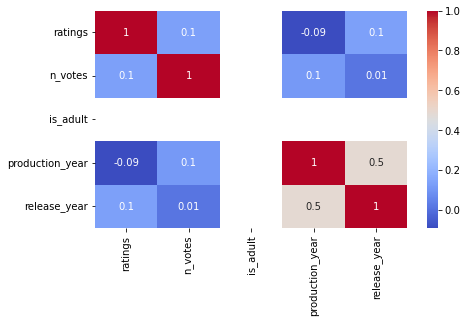

In [3]:
print(X.describe())

plt.figure(figsize=(7,4))
corr = X.corr()
heatmap = sns.heatmap(corr, annot=True, cmap="coolwarm", fmt='.1g')

## Preprocessing the data
### Preprocessing functions

In [4]:
"""
Creating empty DataFrame to start
"""
n_samples = X.shape[0]
data = pd.DataFrame()

In [5]:
"""
Keeping the directly usable features
"""
def get_directrly_usable_features(df):
    directly_usable_features = ["ratings", "n_votes", "is_adult"]
    for feature in directly_usable_features:
        df[feature] = X[feature]
    return df

In [6]:
"""
Dealing with the "production_year" feature
"""

def get_prod_year_feature(df, params):
    
    style = params["production_year_style"] # "per_quantile" / "per_period_length" / "no_period"
    if style != "no_period" :
        n_year_period = params["n_year_period"]

    # Removing previously computed categorie(s) for the "production_year" initial feature

    for feature in df.columns:
        if len(feature) >= 8 and (feature[:6] == "period" or feature == "production_year"):
            df.drop(feature, axis=1, inplace=True)

    # Creating new categorie(s) for the "production_year" initial feature

    prod_year = X["production_year"].copy()
    if style == "per_quantile" or style == "per_period_length":
        categories = np.ones((n_year_period, n_samples))

        if style == "per_quantile":
            thresholds = prod_year.quantile(np.arange(1, n_year_period) / n_year_period)
        else :
            thresholds = np.min(prod_year) + (np.max(prod_year) - np.min(prod_year))*np.arange(1, n_year_period)/n_year_period
        for i, threshold in enumerate(thresholds):
            categories[i+1] = (prod_year >= threshold).astype(int)
            categories[i] -= categories[i+1]
        for period in range(n_year_period):
            df["period {}".format(period)] = categories[period]
    elif style == "no_period":
        df["production_year"] = prod_year
    return df

In [7]:
"""
Dealing with the "runtime" feature

The problem is here that we have some missing values, we have to deal with it.
"""

def get_runtime_feature(df, params):

    # Add other smarter ways ?
    
    replace_type = params["runtime_replace_type"] # "zero" / "mean"
    
    runtime = X["runtime"].copy()
    if replace_type == "zero":
        runtime[runtime == "\\N"] = 0
    if replace_type == "mean":
        mean = np.mean(runtime[runtime != "\\N"].astype(float))
        runtime[runtime == "\\N"] = mean
    df["runtime"] = runtime.astype(float)    
    return df

In [51]:
"""
Dealing with the "studio" feature


Juste rajouter toute les features une par une me semblait un peu lourd (yen a 509), ducoup j'effectue PCA dessus.
Jsp si ça se fait ? (on peut changer l'algo de dimensionality reduction aussi si on veut)
"""

def get_studio_feature(df, params):
    use_PCA = params["studio_use_PCA"]
    if use_PCA :
        dim = params["studio_PCA_dim"]

    # Removing previously computed categorie(s) for the "studio" initial feature
    for feature in df.columns:
        if len(feature) >= 10 and feature[:10] == "studio_PC_":
            df.drop(feature, axis=1, inplace=True)

    # Creating new categorie(s) for the "studio" initial feature
    studio = X["studio"].copy()
    studio_labels = np.unique(studio)
    studio_features = np.zeros((len(studio_labels), n_samples))
    for i, label in enumerate(studio_labels) :
        studio_features[i] = (studio == label).astype(int)
    
    if not use_PCA :
        dim = len(studio_labels)
    # Applying pca or not
    if use_PCA :
        pca = PCA(n_components=dim)
        out = pca.fit_transform(studio_features.T)
    else :
        normals = studio_features[np.count_nonzero(studio_features, axis=1) > 2].T
        outliers = np.sum(studio_features[np.count_nonzero(studio_features, axis=1) <= 2].T, axis = 1)
        out = np.zeros((normals.shape[0], normals.shape[1] + 1))
        out[:, :-1] = normals
        out[:, -1] = outliers
        dim = out.shape[1]
    
    df[["studio_PC_{}".format(i) for i in range(dim)]] = out
    return df

# Ya plein de warnings quand dim trop grand ou pas de PCA /: 
# jsp comment regler ça... en utilisant pd.concat ça tourne vraiment extrêmement lentement

In [9]:
"""
Dealing with the "genres" feature

Je rajoute juste une feature par genre, j'espère ça suffit ? -> pt-être dimension reduction sur ça aussi ?
Certains films ont pas de genre attitré (genre = "\\N"),
ce que j'ai fait ici considère ça comme un genre à part entière, ptet on peut deal le truc autrement ?
"""

def get_genre_feature(df):

    X.loc[X["genres"] == "\\N", "genres"] = "Others"
    all_genres = X["genres"].copy()
    diff_genres = []

    for genres in np.unique(all_genres):
        for genre in genres.split(",") :
            if not genre in diff_genres :
                diff_genres.append(genre)

    for genre in diff_genres:
        df[genre] = [1 if genre in genres.split(",") else 0 for genres in all_genres]  
    return df

In [10]:
"""
Dealing with the "text_embeddings" feature


Dimension of embedding space is too high -> dimensionnality reduction
J'utilise que PCA pr l'instant ici aussi
"""
def get_text_embedding_feature(df, params):
    
    output_dim = params["text_embedding_PCA_dim"] # output dimension of PCA

    # Removing previously computed categorie(s) for the "text_embedding" initial feature
    for feature in df.columns:
        if len(feature) >= 18 and feature[:18] == "text_embedding_PC_":
            df.drop(feature, axis=1, inplace=True)

    # Creating new categorie(s) for the "text_embedding" initial feature
    text_embeddings = X["text_embeddings"]
    input_dim = 768
    embeddings = np.zeros((n_samples, input_dim))
    for i, text_embedding in enumerate(text_embeddings):
        embeddings[i] = list(map(float,text_embedding[1:-1].split(",")))

    # applying PCA
    pca = PCA(n_components=output_dim)
    output = pca.fit_transform(embeddings)

    df[["text_embedding_PC_{}".format(i) for i in range(output_dim)]] = output
    return df

In [11]:
"""
Dealing with the "img_embeddings" feature


Dimension of embedding space is too high -> dimensionnality reduction
J'utilise que PCA pr l'instant ici aussi
"""
def get_img_embedding_feature(df, params):
    output_dim = params["img_embedding_PCA_dim"] # output dimension of PCA

    # Removing previously computed categorie(s) for the "img_embedding" initial feature
    for feature in df.columns:
        if len(feature) >= 17 and feature[:17] == "img_embedding_PC_":
            df.drop(feature, axis=1, inplace=True)

    # Creating new categorie(s) for the "img_embedding" initial feature
    img_embeddings = X["img_embeddings"]
    input_dim = 2048
    embeddings = np.zeros((n_samples, input_dim))
    for i, img_embedding in enumerate(img_embeddings):
        embeddings[i] = list(map(float,img_embedding[1:-1].split(",")))

    # applying PCA
    pca = PCA(n_components=output_dim)
    output = pca.fit_transform(embeddings)

    df[["img_embedding_PC_{}".format(i) for i in range(output_dim)]] = output
    return df

In [12]:
def create_preprocessed(params):
    df = pd.DataFrame()
    df = get_directrly_usable_features(df)
    df = get_genre_feature(df)
    df = get_img_embedding_feature(df, params)
    df = get_prod_year_feature(df, params)
    df = get_runtime_feature(df, params)
    df = get_studio_feature(df, params)
    df = get_text_embedding_feature(df, params)
    return df

### Preprocessing execution

In [13]:
"""
Example of data preprocessing
"""

params = {
    "production_year_style" : "per_quantile", # "per_quantile" / "per_period_length" / "no_period"
    "n_year_period" : 5,
    "runtime_replace_type" : "mean", # "mean" / "zero"
    "studio_use_PCA" : True,
    "studio_PCA_dim" : 50,
    "text_embedding_PCA_dim" : 50,
    "img_embedding_PCA_dim" : 50
}

preprocessed_data = create_preprocessed(params)

C:\Users\hugov\AppData\Local\Temp\ipykernel_15068\506335960.py:37: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[["studio_PC_{}".format(i) for i in range(dim)]] = out
C:\Users\hugov\AppData\Local\Temp\ipykernel_15068\506335960.py:37: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[["studio_PC_{}".format(i) for i in range(dim)]] = out
C:\Users\hugov\AppData\Local\Temp\ipykernel_15068\506335960.py:37: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has

C:\Users\hugov\AppData\Local\Temp\ipykernel_15068\506335960.py:37: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[["studio_PC_{}".format(i) for i in range(dim)]] = out
C:\Users\hugov\AppData\Local\Temp\ipykernel_15068\506335960.py:37: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[["studio_PC_{}".format(i) for i in range(dim)]] = out
C:\Users\hugov\AppData\Local\Temp\ipykernel_15068\506335960.py:37: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has

C:\Users\hugov\AppData\Local\Temp\ipykernel_15068\431448954.py:28: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[["text_embedding_PC_{}".format(i) for i in range(output_dim)]] = output
C:\Users\hugov\AppData\Local\Temp\ipykernel_15068\431448954.py:28: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[["text_embedding_PC_{}".format(i) for i in range(output_dim)]] = output
C:\Users\hugov\AppData\Local\Temp\ipykernel_15068\431448954.py:28: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling 

C:\Users\hugov\AppData\Local\Temp\ipykernel_15068\431448954.py:28: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[["text_embedding_PC_{}".format(i) for i in range(output_dim)]] = output
C:\Users\hugov\AppData\Local\Temp\ipykernel_15068\431448954.py:28: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[["text_embedding_PC_{}".format(i) for i in range(output_dim)]] = output
C:\Users\hugov\AppData\Local\Temp\ipykernel_15068\431448954.py:28: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling 

In [14]:
preprocessed_data.head()

,ratings,n_votes,is_adult,Action,Adventure,Animation,Comedy,Crime,Documentary,Drama,...,text_embedding_PC_40,text_embedding_PC_41,text_embedding_PC_42,text_embedding_PC_43,text_embedding_PC_44,text_embedding_PC_45,text_embedding_PC_46,text_embedding_PC_47,text_embedding_PC_48,text_embedding_PC_49
0,6.5,92937.0,0,0,1,0,1,0,0,1,...,-0.002927,-0.011446,-0.000431,-0.012212,-0.053398,-0.074628,-0.023339,-0.020060,0.076783,0.031401
1,7.9,11.0,0,1,0,0,0,1,0,1,...,-0.045052,-0.015828,0.056369,0.002694,0.065240,-0.053266,0.031456,-0.025050,-0.043222,0.103794
2,5.9,1345.0,0,0,0,0,0,0,0,1,...,-0.000623,-0.052100,-0.022411,-0.031955,0.003196,0.068902,-0.063013,-0.034026,-0.013514,0.036906
3,6.6,4851.0,0,0,0,0,0,0,0,1,...,-0.082248,-0.053315,0.016410,0.064771,0.031312,-0.049172,-0.122244,-0.007223,0.108746,0.029535
4,4.1,549.0,0,0,0,0,0,1,0,1,...,-0.019778,0.087705,0.008588,-0.039261,0.014582,0.020271,0.079182,-0.005455,-0.033858,-0.019978


### Data visualisation

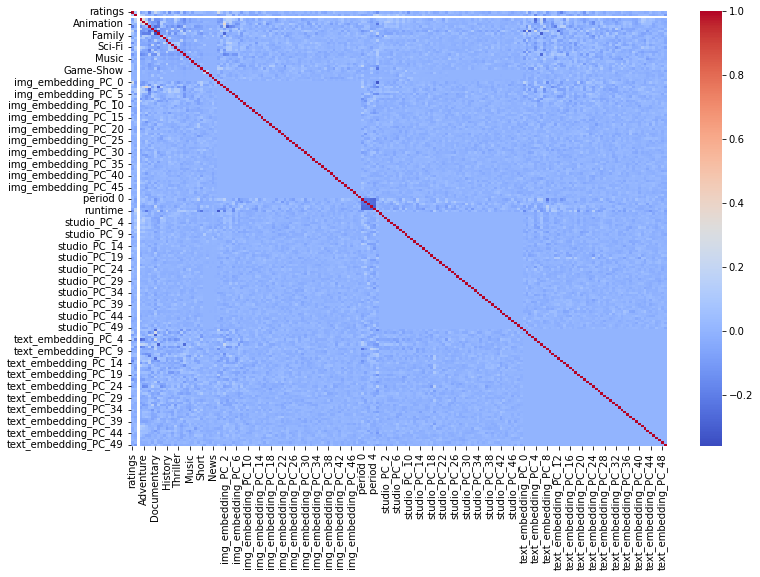

In [15]:
plt.figure(figsize=(12,8))
corr = preprocessed_data.corr()

heatmap = sns.heatmap(corr, cmap="coolwarm")

### Feature Selection


In [16]:
# Creer un data training/validation splités a partir du X1 (on garde X2 pour les vrais tests) 
X_train, X_test, y_train, y_test = train_test_split(preprocessed_data, Y1, test_size = 0.2, random_state=1)

In [17]:
# Score computation : Root Mean Square Error

def compute_rmse(predict, target):
    return mean_squared_error(predict, target, squared=False)

def compute_rmse2(predict, target):
    if len(target.shape) == 2:
        target = target.squeeze()
    if len(predict.shape) == 2:
        predict = predict.squeeze()
    diff = target - predict
    if len(diff.shape) == 1:
        diff = np.expand_dims(diff, axis=-1)
    rmse = np.sqrt(diff.T@diff / diff.shape[0])
    return float(rmse)

In [18]:
def perform_grid_search(model_, params, scoring,X_train, y_train):

    clf = Rando(model_, params, cv=5, scoring=scoring, n_jobs=-1)
    grid_result = clf.fit(X_train,y_train)
    print("clf.best_score_: ", clf.best_score_)
    print("clf.best_params_: ",clf.best_params_)
    return grid_result
 

In [19]:
def perform_grid_search(model_, params, scoring,X_train, y_train):

    clf = GridSearchCV(model_, params, cv=5, scoring=scoring, n_jobs=-1)
    grid_result = clf.fit(X_train,y_train)
    print("clf.best_score_: ", clf.best_score_)
    print("clf.best_params_: ",clf.best_params_)
    return grid_result
 

In [20]:
from sklearn.feature_selection import mutual_info_regression
scores = mutual_info_regression(X_train, np.ravel(y_train))

### Linear Regression

In [21]:
def fit_predict_with_features(X_train,Y_train, X_test, Y_test, selected_features):
    X_train_filtered = X_train[selected_features]
    X_test_filtered = X_test[selected_features]
    
    clf = LinearRegression(n_jobs=-1)
    clf.fit(X_train_filtered,Y_train)
    y_pred = clf.predict(X_test_filtered)

    return y_pred

In [22]:
print('By selecting features')
# Dans ce cas, on selectionne tout
Y_pred = fit_predict_with_features(X_train,y_train, X_test, y_test, X_train.columns)

linear_regressor_score = cross_val_score(LinearRegression(), preprocessed_data, Y1, cv=5)
print(np.mean(linear_regressor_score))

By selecting features
0.3905746039820138


In [52]:
import copy
import warnings
warnings.simplefilter("ignore")


class Solution:
    def __init__(self, params, score):
        self.params = params
        self.score = score

class LocalSearch :
    
    def __init__(self, regressor, params):
        self.regressor = regressor
        self.params = params
        self.visited = []
    
    def is_visited(self, params):
        return str(params) in self.visited
    
    def get_solution(self, params):
        preprocessed_data = create_preprocessed(params)
        current_score = np.mean(cross_val_score(regressor, preprocessed_data, Y1, cv=5))
        self.visited.append(str(params))
        return Solution(params, current_score)
    
    def initiate(self):
        current_params = {}
        for param in self.params.keys():
            current_params[param] = np.random.choice(self.params[param])
        self.current_solution = self.get_solution(current_params)
        self.best_solution = copy.deepcopy(self.current_solution)
    
    def transitions(self):
        neighbors = []
        current_params = self.current_solution.params
        for param in self.params.keys():
            copied = copy.deepcopy(self.params[param])
            np.random.shuffle(copied)
            for value in copied:
                new_params = copy.deepcopy(current_params)
                new_params[param] = value
                if not self.is_visited(new_params):
                    neighbors.append(new_params)
                    break
        return neighbors
    
    def choose(self, neighbors, n):
        if len(neighbors) <= n :
            return neighbors
        return np.random.choice(neighbors, size=n, replace = False)
    
    def get_difference(self, other):
        first = self.current_solution.params
        for param in first.keys():
            if first[param] != other[param]:
                return param, first[param], other[param]
        return None
    
    def compute(self):
        self.initiate()
        print("INITIALISATION ENDED : initial score of {:.2%}".format(self.best_solution.score))
        no_upgrade = 0;
        while no_upgrade <= 10:
            neighbors = self.transitions()
            if len(neighbors) == 0:
                break
            neighbors = self.choose(neighbors, 3)
            curr_best_sol = Solution(None, 0.0)
            for neighbor in neighbors :
                solution = self.get_solution(neighbor)
                if solution.score > curr_best_sol.score :
                    curr_best_sol = solution
                diff = self.get_difference(neighbor)
                print("{} : {} -> {} score {:.2%}".format(diff[0], diff[1], diff[2],solution.score))
            self.current_solution = curr_best_sol
            print("updated current")
            if curr_best_sol.score >= self.best_solution.score:
                self.best_solution = copy.deepcopy(curr_best_sol)
                print("SOLUTION UPGRADED : new score of {:.2%}".format(self.best_solution.score))
                no_upgrade = 0
            no_upgrade += 1
        
params = {
    "production_year_style" : ["per_quantile", "per_period_length", "no_period"], # "per_quantile" / "per_period_length" / "no_period"
    "n_year_period" : [3, 5, 10],
    "runtime_replace_type" : ["mean", "zero"], # "mean" / "zero"
    "studio_use_PCA" : [False],
    "studio_PCA_dim" : [1, 10],
    "text_embedding_PCA_dim" : [1, 10],
    "img_embedding_PCA_dim" : [1, 10]
}

regressor = LinearRegression()
localsearch = LocalSearch(regressor, params)
localsearch.compute()

INITIALISATION ENDED : initial score of 39.52%
img_embedding_PCA_dim : 10 -> 1 score 39.48%
text_embedding_PCA_dim : 10 -> 1 score 38.77%
production_year_style : per_quantile -> no_period score 39.29%
updated current
studio_PCA_dim : 1 -> 10 score 39.48%
text_embedding_PCA_dim : 10 -> 1 score 38.63%
production_year_style : per_quantile -> per_period_length score 39.41%
updated current
img_embedding_PCA_dim : 1 -> 10 score 39.52%
runtime_replace_type : mean -> zero score 39.93%
n_year_period : 5 -> 10 score 39.62%
updated current
SOLUTION UPGRADED : new score of 39.93%
img_embedding_PCA_dim : 1 -> 10 score 39.85%
studio_PCA_dim : 10 -> 1 score 39.93%
production_year_style : per_quantile -> no_period score 39.75%
updated current
SOLUTION UPGRADED : new score of 39.93%
n_year_period : 5 -> 10 score 39.97%
text_embedding_PCA_dim : 10 -> 1 score 39.53%
img_embedding_PCA_dim : 1 -> 10 score 39.85%
updated current
SOLUTION UPGRADED : new score of 39.97%
studio_PCA_dim : 1 -> 10 score 39.97%
n

In [53]:
print(localsearch.best_solution.score)
print(localsearch.best_solution.params)

0.39974832960984524
{'production_year_style': 'per_quantile', 'n_year_period': 10, 'runtime_replace_type': 'zero', 'studio_use_PCA': False, 'studio_PCA_dim': 1, 'text_embedding_PCA_dim': 10, 'img_embedding_PCA_dim': 1}


### Search on Forest

In [ ]:
# Définir les valeurs à tester pour les hyperparamètres du modèle
params =    {"n_estimators": [500], 
            "criterion": ["squared_error"], # ["squared_error", "absolute_error", "poisson"],
            "max_depth": [1],               # [None, 1, 2, 3],
            "min_samples_split": [1.0],       # [1, 2, 3],
            "max_features" : ["sqrt"],      # ["sqrt", "log2", None]
            }

rfr = RandomForestRegressor(n_jobs=-1,random_state=0)
scoring = "neg_mean_squared_error"

grid = perform_grid_search(rfr, params, scoring, X_train, y_train)
pred = grid.best_estimator_.predict(X_test)
print("pred: ",pred.mean())

print("Score")
model = grid.best_estimator_
print(model.score(X_test,y_test))
rmse = compute_rmse(pred, y_test)
rmse

### GridSearch on KNN

In [ ]:
# Définir les valeurs à tester pour les hyperparamètres du modèle
params =    {'n_neighbors' : range(3, 40), 
            'weights' : ['uniform', 'distance']}
knn = KNeighborsRegressor(n_jobs=-1)
scoring = "neg_mean_squared_error"

grid = perform_grid_search(knn, params, scoring, X_train, y_train)
pred = grid.best_estimator_.predict(X_test)
print("pred: ",pred.mean())

print("Score")
model = grid.best_estimator_
print(model.score(X_test,y_test))
rmse = compute_rmse(pred, y_test)
rmse

In [ ]:
# Score for each training subset
N, train_score, val_score = learning_curve(knn, X_train, y_train, cv=5)

plt.plot(N, train_score.mean(axis=1), label='train')
plt.plot(N, val_score.mean(axis=1), label='validation')
plt.xlabel("train size")
plt.legend()
plt.show()

In [ ]:
# Evaluation metrics from the gridsearch
res = pd.DataFrame(grid.cv_results_.values(), ).transpose()
res.columns=grid.cv_results_.keys()
res